In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    lives = obs[2:9,52:59]
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype(np.uint8) / 255
    obs[obs > 0] = 1
    return [obs,lives]

Welcome to AI Breakout!
Starting Test Game...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


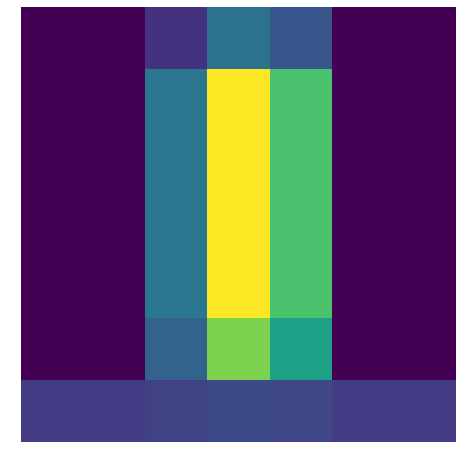

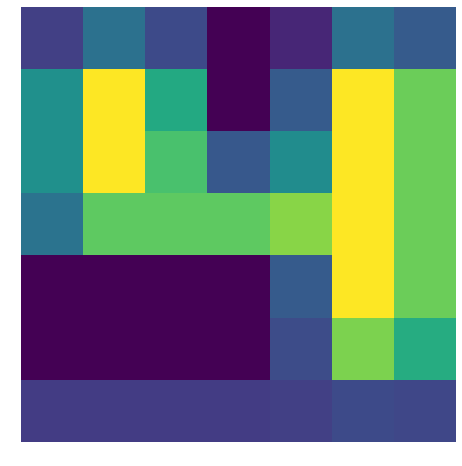

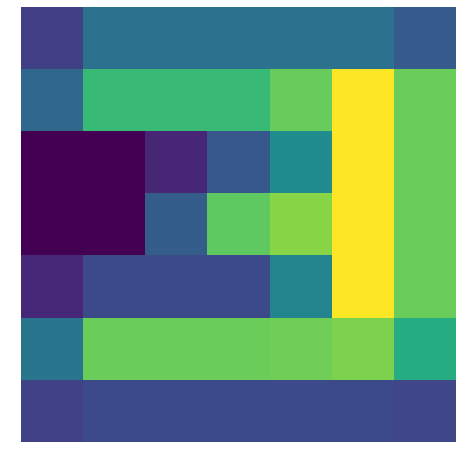

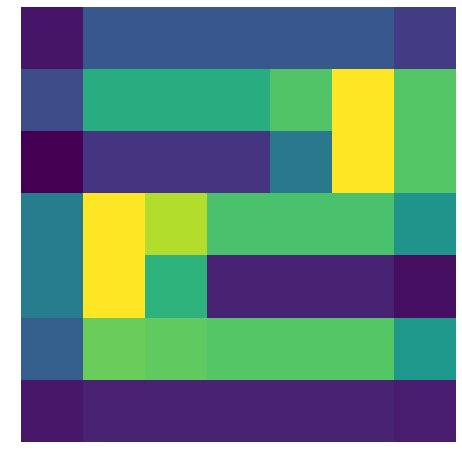

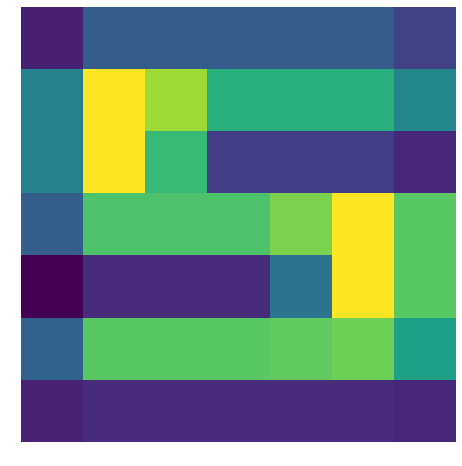

In [4]:
episodes = 1
env = gym.make("Breakout-v0")
init = env.reset()

for i in range(episodes):
    print("Welcome to AI Breakout!")
    print("Starting Test Game...\n")

    
    game = True
    LIVES = []
    while game:
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        LIVES.append(lives)
        
        if done:
            
            LIVES = np.unique(np.array(LIVES), axis=0)
            
            for i in LIVES:
                plot_state(i.reshape(7,7))
            game = False
            observation = env.reset()
                             
        else:
            pass
            
         

In [5]:
env = gym.make("Breakout-v0")
init = env.reset()

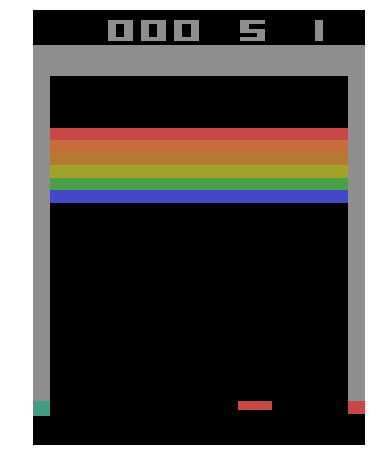

In [6]:
plot_state(init)

In [7]:
init.shape

(210, 160, 3)

In [8]:
I = process_obs(init)[0]

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [9]:
I.shape

(84, 84, 1)

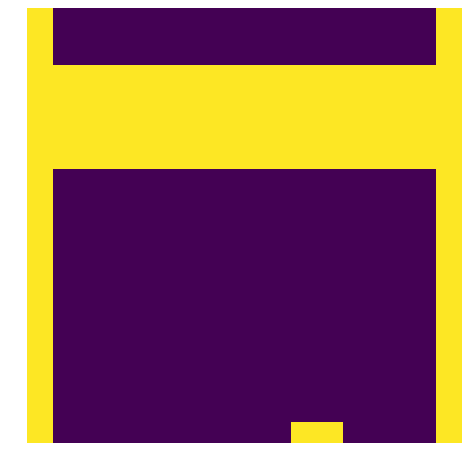

In [10]:
plot_state(I.reshape(84,84))

In [11]:
env.action_space

Discrete(4)

In [12]:
inp = Input(shape=(84,84,4))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,4))(inp)
x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(256,  activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.01, patience=2, mode = min, verbose = 1)]
model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               663808    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_________________________________________________________________
None

/Users/samwilliams/homebrew/lib/python3.7/site-packages/keras/callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [13]:
LIFE = {}
LIFE["1"] = LIVES[0]
LIFE["2"] = LIVES[3]
LIFE["3"] = LIVES[2]
LIFE["4"] = LIVES[1]
LIFE["5"] = LIVES[4]

In [14]:
for i,j in LIFE.items():
    print(i)

1
2
3
4
5


In [15]:
full_episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

In [16]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 500
episode_scores = []
epsilon = 0.5
gamma = 0.99
done = False

for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    LIVES = []
    observation_batch = []
    reward_batch = []
    episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

    
    
    while game: 
        
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                rand = np.random.uniform(0,1)
                if  rand < epsilon:
                    action = env.action_space.sample()
                else:
                    observation = np.expand_dims(episode_history["state"][-1],0)
                    action = np.argmax(model.predict(observation))
                
                if len(episode_history["state"]) > 2:
                    if np.array_equal(episode_history["state"][-1], episode_history["state"][-2]):
                        action = 1
                    else:
                        pass
                else:
                    pass
                observation_batch = []
                reward_batch = []
                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        
        if len(LIVES) == 0:
            LIVES.append(lives)
            loss = 0
        else:
            if np.array_equal(LIVES[-1], lives):
                loss = 0
            else:
                LIVES.append(lives)
                loss = -10
                
        observation_batch.append(observation)
        reward_batch.append(10*reward+loss)        
        
        if (frame % 4 == 0):
            if frame == 4:
                episode_history["state"] = np.concatenate([i for i in observation_batch], axis=-1)
                episode_history["state"] = np.expand_dims(episode_history["state"],0)

            else:
                obs = np.concatenate([i for i in observation_batch], axis=-1)
                obs = np.expand_dims(obs,0)
                episode_history["state"] = np.concatenate([episode_history["state"], obs], axis=0)

            episode_history["reward"] = np.concatenate([episode_history["reward"], np.array([np.sum(reward_batch)])], axis = 0)  
            episode_history["action"] = np.concatenate([episode_history["action"], np.array([action])], axis=0)
         
        sum += reward
        frame += 1
        
        
        
        
        if done:

            for j,k in enumerate(episode_history["reward"][::-1]):
                
                if j == 0:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1])] = k
                    Q = val
                else:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1-j])] = k + gamma*np.sum(Q[-1])
                    Q = np.concatenate([Q,val], axis = 0)
                    
            Q = Q[::-1]
            episode_history["Q"] = Q
                        
            if i == 1:
                full_episode_history["state"] = episode_history["state"]
                full_episode_history["Q"] = episode_history["Q"]
            else:
                full_episode_history["state"] = np.concatenate([full_episode_history["state"], episode_history["state"]], axis = 0)
                full_episode_history["Q"] = np.concatenate([full_episode_history["Q"], episode_history["Q"]], axis = 0)

            full_episode_history["reward"] = np.concatenate([full_episode_history["reward"], episode_history["reward"]], axis = 0)
            full_episode_history["action"] = np.concatenate([full_episode_history["action"], episode_history["action"]], axis = 0)
            
            
            print("Training the model from a random batch...")
            
            rand = np.random.choice([i for i in range(full_episode_history["action"].shape[0])], size=32)
            inp = full_episode_history["state"][rand]
            target = full_episode_history["Q"][rand]
            model.fit(inp, target, epochs = 3, batch_size=8, verbose=1)
            print("Total game score was: {}".format(int(sum)))
            print("Epsilon: {}\n".format(epsilon))
            
            observation = env.reset()
            observation, lives = process_obs(observation)
            episode_scores.append(int(sum))
            epsilon *= 0.999
            if epsilon < 0.1:
                epsilon = 0.1
            game = False
            frame = 0
 
                             
        else:
            pass
            
         

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 5ms/step - loss: 41.1616 - mean_absolute_error: 2.8873
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 40.5106 - mean_absolute_error: 2.9878
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 40.1744 - mean_absolute_error: 3.1382
Total game score was: 2
Epsilon: 0.5

Welcome to AI Breakout!
Starting Game 2 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 20.4900 - mean_absolute_error: 2.1372
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 20.2584 - mean_absolute_error: 1.9745
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 20.1811 - mean_absolute_error: 1.9645
Total game score was: 2
Epsilon: 0.4995

Welcome to AI Breakout!
Starting Game 3 of 500...

Training the model from a rand

32/32 [==============================] - 0s 2ms/step - loss: 48.2800 - mean_absolute_error: 3.3986
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 47.6069 - mean_absolute_error: 3.5829
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 46.6428 - mean_absolute_error: 3.6183
Total game score was: 1
Epsilon: 0.4915676611869122

Welcome to AI Breakout!
Starting Game 19 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 48.5289 - mean_absolute_error: 3.9118
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 48.1580 - mean_absolute_error: 3.7351
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 47.8130 - mean_absolute_error: 3.6276
Total game score was: 0
Epsilon: 0.4910760935257253

Welcome to AI Breakout!
Starting Game 20 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step

32/32 [==============================] - 0s 2ms/step - loss: 30.1297 - mean_absolute_error: 3.1463
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 29.8312 - mean_absolute_error: 3.0776
Total game score was: 3
Epsilon: 0.48327753104954174

Welcome to AI Breakout!
Starting Game 36 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 64.5667 - mean_absolute_error: 4.3940
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 64.5503 - mean_absolute_error: 4.7679
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 63.7200 - mean_absolute_error: 4.9342
Total game score was: 1
Epsilon: 0.4827942535184922

Welcome to AI Breakout!
Starting Game 37 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 33.5753 - mean_absolute_error: 3.5858
Epoch 2/3
32/32 [==============================] - 0s 2ms/ste

32/32 [==============================] - 0s 1ms/step - loss: 66.6782 - mean_absolute_error: 4.6577
Total game score was: 0
Epsilon: 0.4751272112844172

Welcome to AI Breakout!
Starting Game 53 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 39.4610 - mean_absolute_error: 3.5619
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 38.7678 - mean_absolute_error: 3.4941
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 38.1680 - mean_absolute_error: 3.5052
Total game score was: 1
Epsilon: 0.4746520840731328

Welcome to AI Breakout!
Starting Game 54 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 47.2501 - mean_absolute_error: 3.3636
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 46.6571 - mean_absolute_error: 3.2411
Epoch 3/3
32/32 [==============================] - 0s 1ms/step

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 47.6796 - mean_absolute_error: 3.8964
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 46.9562 - mean_absolute_error: 3.9833
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 46.6943 - mean_absolute_error: 3.7836
Total game score was: 2
Epsilon: 0.466647229690647

Welcome to AI Breakout!
Starting Game 71 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 46.9694 - mean_absolute_error: 4.0836
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 45.9094 - mean_absolute_error: 4.1471
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 45.4142 - mean_absolute_error: 4.1613
Total game score was: 1
Epsilon: 0.46618058246095634

Welcome to AI Breakout!
Starting Game 72 of 500...

Training the model from a random batch...
Epoch 1/3


32/32 [==============================] - 0s 2ms/step - loss: 51.5090 - mean_absolute_error: 4.0378
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 51.0230 - mean_absolute_error: 3.9920
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 50.6940 - mean_absolute_error: 4.1202
Total game score was: 1
Epsilon: 0.4587773745967664

Welcome to AI Breakout!
Starting Game 88 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 48.7723 - mean_absolute_error: 3.9797
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 47.4500 - mean_absolute_error: 3.6794
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 46.0399 - mean_absolute_error: 3.6682
Total game score was: 1
Epsilon: 0.4583185972221696

Welcome to AI Breakout!
Starting Game 89 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step

32/32 [==============================] - 0s 1ms/step - loss: 38.8092 - mean_absolute_error: 3.3330
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 38.9427 - mean_absolute_error: 3.3639
Total game score was: 0
Epsilon: 0.4510402420720088

Welcome to AI Breakout!
Starting Game 105 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 48.0288 - mean_absolute_error: 3.6653
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 46.1230 - mean_absolute_error: 3.6159
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 45.2544 - mean_absolute_error: 3.6571
Total game score was: 0
Epsilon: 0.45058920182993684

Welcome to AI Breakout!
Starting Game 106 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 42.2735 - mean_absolute_error: 3.5677
Epoch 2/3
32/32 [==============================] - 0s 2ms/s

32/32 [==============================] - 0s 2ms/step - loss: 43.8310 - mean_absolute_error: 4.2504
Total game score was: 1
Epsilon: 0.4434335937930322

Welcome to AI Breakout!
Starting Game 122 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 31.1241 - mean_absolute_error: 3.6555
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 30.2053 - mean_absolute_error: 3.3983
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 29.4873 - mean_absolute_error: 3.4050
Total game score was: 1
Epsilon: 0.4429901601992392

Welcome to AI Breakout!
Starting Game 123 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 46.4160 - mean_absolute_error: 3.8625
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 45.3089 - mean_absolute_error: 3.8511
Epoch 3/3
32/32 [==============================] - 0s 1ms/st

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 43.0122 - mean_absolute_error: 3.7293
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 41.2561 - mean_absolute_error: 3.5210
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 40.4860 - mean_absolute_error: 3.5106
Total game score was: 2
Epsilon: 0.43551927395591117

Welcome to AI Breakout!
Starting Game 140 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 34.2237 - mean_absolute_error: 3.4338
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 33.6835 - mean_absolute_error: 3.3052
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 32.7946 - mean_absolute_error: 3.3778
Total game score was: 1
Epsilon: 0.43508375468195526

Welcome to AI Breakout!
Starting Game 141 of 500...

Training the model from a random batch...
Epoch 

32/32 [==============================] - 0s 2ms/step - loss: 38.5049 - mean_absolute_error: 4.0089
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 36.0865 - mean_absolute_error: 3.6513
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 35.2493 - mean_absolute_error: 3.6783
Total game score was: 0
Epsilon: 0.4281743818006586

Welcome to AI Breakout!
Starting Game 157 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 39.7089 - mean_absolute_error: 3.6054
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 37.1991 - mean_absolute_error: 3.7229
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 35.3771 - mean_absolute_error: 3.5152
Total game score was: 0
Epsilon: 0.42774620741885794

Welcome to AI Breakout!
Starting Game 158 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/s

32/32 [==============================] - 0s 2ms/step - loss: 40.9160 - mean_absolute_error: 3.5756
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 40.2045 - mean_absolute_error: 3.4097
Total game score was: 1
Epsilon: 0.4209533588838034

Welcome to AI Breakout!
Starting Game 174 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 35.4675 - mean_absolute_error: 3.2061
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 33.7812 - mean_absolute_error: 3.2248
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 32.9291 - mean_absolute_error: 3.3471
Total game score was: 0
Epsilon: 0.4205324055249196

Welcome to AI Breakout!
Starting Game 175 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 47.3873 - mean_absolute_error: 4.1444
Epoch 2/3
32/32 [==============================] - 0s 2ms/st

32/32 [==============================] - 0s 2ms/step - loss: 57.7375 - mean_absolute_error: 4.6520
Total game score was: 3
Epsilon: 0.41385411619057216

Welcome to AI Breakout!
Starting Game 191 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 44.5431 - mean_absolute_error: 4.2320
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 41.9729 - mean_absolute_error: 3.6838
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 40.2990 - mean_absolute_error: 3.5413
Total game score was: 0
Epsilon: 0.4134402620743816

Welcome to AI Breakout!
Starting Game 192 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 50.1097 - mean_absolute_error: 4.0015
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 48.0745 - mean_absolute_error: 4.2404
Epoch 3/3
32/32 [==============================] - 0s 2ms/s

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 50.6852 - mean_absolute_error: 3.6681
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 46.7692 - mean_absolute_error: 3.7372
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 44.8951 - mean_absolute_error: 3.6056
Total game score was: 2
Epsilon: 0.4064677253368155

Welcome to AI Breakout!
Starting Game 209 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 37.5837 - mean_absolute_error: 3.5120
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 34.6969 - mean_absolute_error: 3.4655
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 32.9517 - mean_absolute_error: 3.5262
Total game score was: 2
Epsilon: 0.4060612576114787

Welcome to AI Breakout!
Starting Game 210 of 500...

Training the model from a random batch...
Epoch 1/

32/32 [==============================] - 0s 2ms/step - loss: 37.0518 - mean_absolute_error: 3.5283
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 35.2267 - mean_absolute_error: 3.3780
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 33.7326 - mean_absolute_error: 3.3889
Total game score was: 2
Epsilon: 0.3996127781835652

Welcome to AI Breakout!
Starting Game 226 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 34.5881 - mean_absolute_error: 3.5220
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 31.7155 - mean_absolute_error: 3.2344
Epoch 3/3
32/32 [==============================] - 0s 1ms/step - loss: 30.5575 - mean_absolute_error: 3.4007
Total game score was: 2
Epsilon: 0.39921316540538165

Welcome to AI Breakout!
Starting Game 227 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/s

32/32 [==============================] - 0s 2ms/step - loss: 45.8922 - mean_absolute_error: 3.4408
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 42.1618 - mean_absolute_error: 3.3830
Total game score was: 0
Epsilon: 0.39287343750419895

Welcome to AI Breakout!
Starting Game 243 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 58.1238 - mean_absolute_error: 4.1865
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 53.5191 - mean_absolute_error: 3.8341
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 51.4710 - mean_absolute_error: 3.7907
Total game score was: 2
Epsilon: 0.39248056406669474

Welcome to AI Breakout!
Starting Game 244 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 29.5900 - mean_absolute_error: 3.1666
Epoch 2/3
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 2ms/step - loss: 47.1494 - mean_absolute_error: 4.2243
Total game score was: 1
Epsilon: 0.3862477536328032

Welcome to AI Breakout!
Starting Game 260 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 38.6142 - mean_absolute_error: 3.7662
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 35.5783 - mean_absolute_error: 3.5966
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 33.4588 - mean_absolute_error: 3.4234
Total game score was: 1
Epsilon: 0.3858615058791704

Welcome to AI Breakout!
Starting Game 261 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 39.7045 - mean_absolute_error: 3.5774
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 36.7482 - mean_absolute_error: 3.4287
Epoch 3/3
32/32 [==============================] - 0s 2ms/st

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 44.2489 - mean_absolute_error: 3.7412
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 41.0517 - mean_absolute_error: 3.5398
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 38.8852 - mean_absolute_error: 3.5080
Total game score was: 5
Epsilon: 0.37935407597416754

Welcome to AI Breakout!
Starting Game 278 of 500...

Training the model from a random batch...
Epoch 1/3
32/32 [==============================] - 0s 2ms/step - loss: 46.5394 - mean_absolute_error: 3.9006
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 41.5083 - mean_absolute_error: 3.7361
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 38.2749 - mean_absolute_error: 3.6060
Total game score was: 2
Epsilon: 0.37897472189819337

Welcome to AI Breakout!
Starting Game 279 of 500...

Training the model from a random batch...
Epoch 

KeyboardInterrupt: 

In [17]:
print(full_episode_history["state"].shape)
print(episode_history["reward"].shape)
print(episode_history["action"].shape)
print(episode_history["Q"].shape)

(20080, 84, 84, 4)
(75,)
(75,)
(75, 4)


In [18]:
print(episode_history["reward"][:])

[  0.   0.   0.   0.   0.   0.   0. -10.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. -10.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  10.   0.   0.   0.   0.   0.
   0.   0.   0.   0. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.  10.   0.   0.   0.   0.   0.   0.   0. -10.   0.   0.   0.
   0.   0.   0.   0.   0.]


In [19]:
print(episode_history["action"])

[1. 0. 3. 2. 2. 1. 3. 3. 2. 0. 2. 3. 1. 0. 1. 1. 3. 0. 3. 1. 3. 2. 1. 0.
 0. 1. 0. 3. 1. 2. 1. 3. 1. 3. 0. 0. 1. 2. 3. 1. 2. 0. 2. 0. 1. 3. 0. 0.
 1. 0. 3. 0. 3. 2. 0. 0. 1. 2. 0. 3. 3. 2. 3. 1. 3. 0. 2. 3. 1. 2. 0. 3.
 2. 1. 3.]


In [20]:
print(episode_history["Q"][10])

[ 0.         0.        -7.8306317  0.       ]


In [21]:
model.predict(np.expand_dims(episode_history["state"][50],0))

array([[-2.076403 , -2.6030765, -2.6146774, -7.621216 ]], dtype=float32)

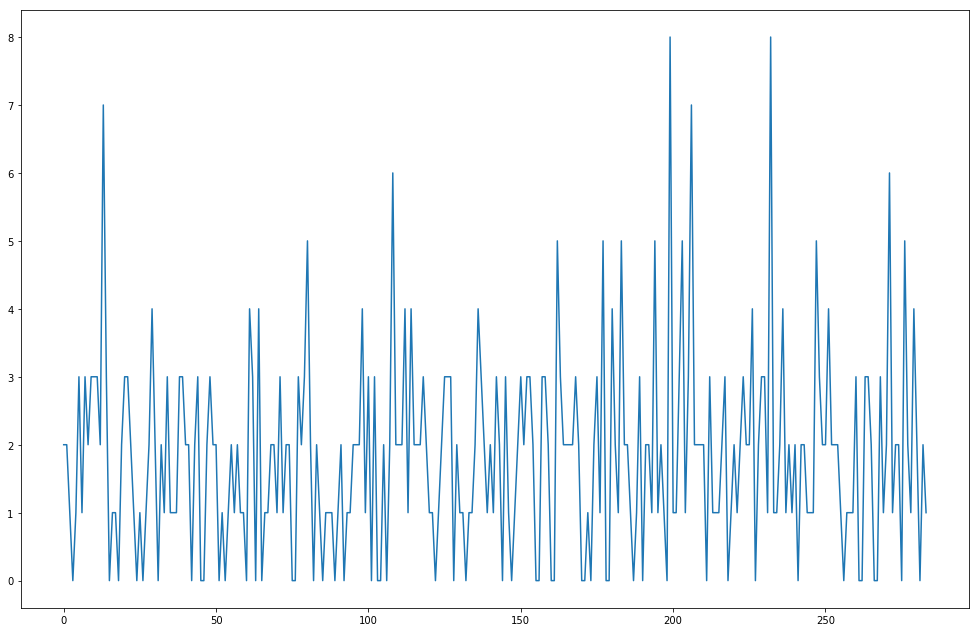

In [22]:
plt.figure(figsize=(17,11))
plt.plot(episode_scores)
plt.show()

# Saving Model

In [23]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [24]:
mod = load_model("breakout-atari-rl.h5")

In [25]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 5
done = False
epsilon = 0


for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    observation_batch = []
    while game:
        
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                action = np.argmax(mod.predict(states)) 

                if np.array_equal(states[0][:84,:84,2], states[0][:84,:84,3]):
                    action = 1
                else:
                    pass
                
                observation_batch = []                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        observation_batch.append(observation)
        
        if (frame % 4 == 0):
            states = np.concatenate([i for i in observation_batch], axis=-1)
            states = np.expand_dims(states,0)


        sum += reward
        frame += 1
        time.sleep(0.02)
        env.render()

        if done:
            print("Total game score was: {}\n".format(int(sum)))
            observation = env.reset()
            observation, lives = process_obs(observation)
            game = False
env.close()        

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 5...
Total game score was: 2

Welcome to AI Breakout!
Starting Game 2 of 5...
Total game score was: 4

Welcome to AI Breakout!
Starting Game 3 of 5...
Total game score was: 5

Welcome to AI Breakout!
Starting Game 4 of 5...
Total game score was: 1

Welcome to AI Breakout!
Starting Game 5 of 5...
Total game score was: 6

